In [29]:
# Imports and connections

import duckdb
import pandas as pd
import matplotlib.pyplot as plt

MADOC_PATH = "D:\Varun Kumar\Proejekt\Data\processed\madoc_all.parquet"
NLP_PATH   = r"D:\Varun Kumar\Proejekt\Data\processed\nlp_sample_full.parquet"

db = duckdb.connect()


In [30]:
# Create a sentiment-ready MADOC table

db.execute("DROP TABLE IF EXISTS madoc_sentiment")

db.execute(f"""
CREATE TABLE madoc_sentiment AS
SELECT
    publish_ts,
    DATE_TRUNC('month', publish_ts) AS month,
    platform,
    community,
    sentiment_vader
FROM read_parquet('{MADOC_PATH}')
WHERE language = 'English'
""")


In [31]:
db.execute("SELECT COUNT(*) FROM madoc_sentiment").fetchdf()


,count_star()
0,20674267


### Emotional temperature of Reddit vs Voat over time.

In [32]:
vader_trends = db.execute("""
SELECT
    month,
    platform,
    AVG(sentiment_vader) AS avg_vader,
    COUNT(*) AS posts
FROM madoc_sentiment
GROUP BY month, platform
ORDER BY month
""").fetchdf()


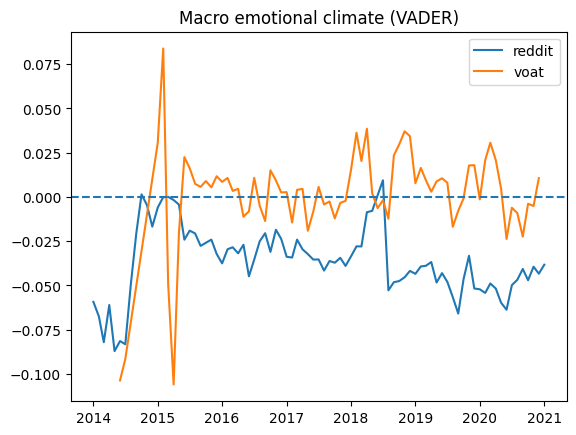

In [33]:
for p in vader_trends["platform"].unique():
    d = vader_trends[vader_trends["platform"] == p]
    plt.plot(d["month"], d["avg_vader"], label=p)

plt.axhline(0, linestyle="--")
plt.title("Macro emotional climate (VADER)")
plt.legend()
plt.show()


In [34]:
engagement = db.execute("""
SELECT
    month,
    platform,
    COUNT(*) AS posts
FROM madoc_sentiment
GROUP BY month, platform
ORDER BY month
""").fetchdf()

engagement["z"] = (
    engagement
    .groupby("platform")["posts"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

spikes = engagement[engagement["z"] > 2]
spikes


,month,platform,posts,z
26,2015-07-01,voat,21142,2.216934
93,2018-04-01,reddit,586712,2.187750
94,2018-05-01,reddit,691980,2.842220
96,2018-06-01,reddit,688379,2.819832
98,2018-07-01,reddit,696898,2.872796


In [35]:
# Loading NLP Sample
nlp = pd.read_parquet(NLP_PATH)

nlp["month"] = pd.to_datetime(nlp["publish_ts"]).dt.to_period("M").dt.to_timestamp()


### Deep emotional & toxicity trends

In [36]:
deep = (
    nlp
    .groupby(["month","platform"])[
        ["sentiment_bert","toxicity","severe_toxicity","identity_attack","threat"]
    ]
    .mean()
    .reset_index()
)


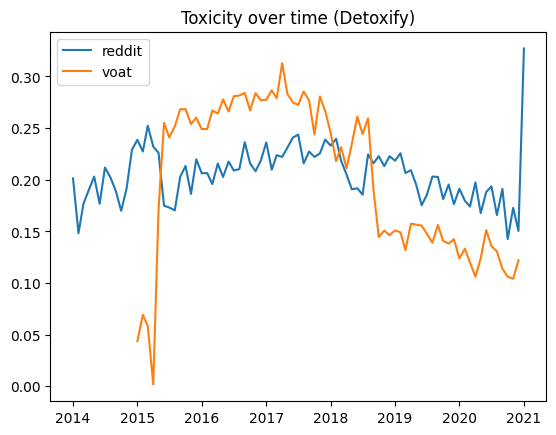

In [37]:
for p in deep["platform"].unique():
    d = deep[deep["platform"] == p]
    plt.plot(d["month"], d["toxicity"], label=p)

plt.title("Toxicity over time (Detoxify)")
plt.legend()
plt.show()


In [38]:
corr = nlp[["sentiment_vader","sentiment_bert","toxicity"]].corr()
corr


,sentiment_vader,sentiment_bert,toxicity
sentiment_vader,1.000000,0.304055,-0.256533
sentiment_bert,0.304055,1.000000,-0.181576
toxicity,-0.256533,-0.181576,1.000000


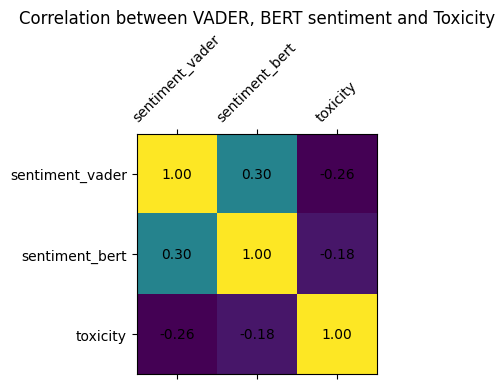

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5,4))

cax = ax.matshow(corr)

# Add numbers inside cells
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

# Axis labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

plt.title("Correlation between VADER, BERT sentiment and Toxicity")
plt.tight_layout()
plt.show()


In [40]:
tox_by_comm = (
    nlp
    .groupby(["community","platform"])[["toxicity","identity_attack","threat","insult"]]
    .mean()
    .reset_index()
)

In [41]:
pivot_tox = tox_by_comm.pivot_table(
    index="community",
    columns="platform",
    values="toxicity"
).reset_index()

pivot_tox["voat_minus_reddit"] = pivot_tox["voat"] - pivot_tox["reddit"]

pivot_tox.sort_values("voat_minus_reddit", ascending=False).head(10)


platform,community,reddit,voat,voat_minus_reddit
2,MensRights,0.189291,0.225288,0.035996
4,greatawakening,0.083301,0.107834,0.024533
0,CringeAnarchy,0.253844,0.269963,0.016119
3,fatpeoplehate,0.281269,0.272251,-0.009018
5,milliondollarextreme,0.263011,0.227832,-0.035179
1,KotakuInAction,0.176537,0.136951,-0.039586


### Community-Level Toxicity

#### Who becomes most harmful after migration?

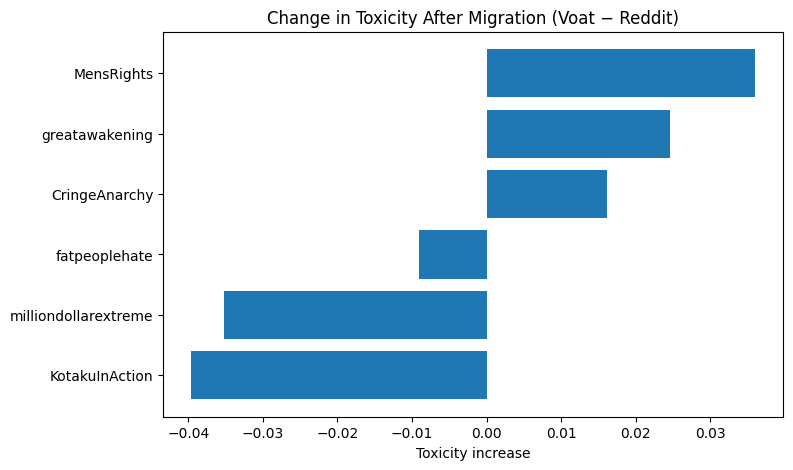

In [42]:
import matplotlib.pyplot as plt

pivot_tox = pivot_tox.sort_values("voat_minus_reddit")

plt.figure(figsize=(8,5))
plt.barh(pivot_tox["community"], pivot_tox["voat_minus_reddit"])
plt.title("Change in Toxicity After Migration (Voat − Reddit)")
plt.xlabel("Toxicity increase")
plt.show()


In [43]:
engagement = db.execute("SELECT * FROM engagement").fetchdf()

In [44]:
merged = pd.merge(engagement, tox_time, on=["month","platform"])
merged.head()


,month,platform,posts,z,toxicity
0,2014-01-01,reddit,38316,-1.221725,0.201304
1,2014-02-01,reddit,35283,-1.240581,0.148211
2,2014-03-01,reddit,43009,-1.192547,0.176644
3,2014-04-01,reddit,40761,-1.206524,0.190330
4,2014-05-01,reddit,52513,-1.133459,0.203039


In [45]:
merged[["posts","toxicity"]].corr()


,posts,toxicity
posts,1.000000,0.118519
toxicity,0.118519,1.000000


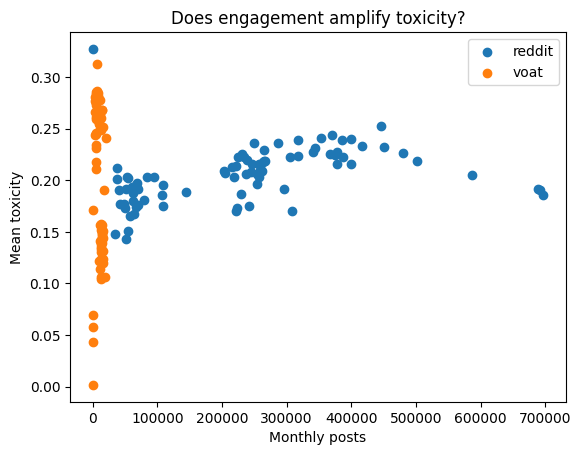

In [46]:
for p in merged["platform"].unique():
    d = merged[merged["platform"] == p]
    plt.scatter(d["posts"], d["toxicity"], label=p)

plt.xlabel("Monthly posts")
plt.ylabel("Mean toxicity")
plt.legend()
plt.title("Does engagement amplify toxicity?")
plt.show()
